# Auto Tagging Support Tickets Using LLM
## Objective:
Automatically tag support tickets into categories using a large language model (LLM).
## Dataset:
Free-text Support Ticket Dataset

In [1]:
!pip install transformers torch accelerate

In [2]:
from transformers import pipeline
import pandas as pd

In [3]:
data = {
    "ticket": [
        "Internet connection drops frequently",
        "Unable to reset my account password",
        "Charged twice for my monthly subscription",
        "Application crashes when uploading files",
        "Need help changing my billing address"
    ]
}

df = pd.DataFrame(data)
df

,ticket
0,Internet connection drops frequently
1,Unable to reset my account password
2,Charged twice for my monthly subscription
3,Application crashes when uploading files
4,Need help changing my billing address


In [4]:
#Define ticket category
TAGS = [
    "Network Issue",
    "Login Problem",
    "Billing Issue",
    "Technical Bug",
    "Account Management"
]

In [5]:
# Load LLM (Zero-Shot)
classifier = pipeline(
    "text2text-generation",
    model="google/flan-t5-base",   # FLAN-T5
    max_length=128
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [6]:
def zero_shot_tag(ticket):    #promting
    prompt = f"""
You are a support ticket classifier.

Ticket:
"{ticket}"

Possible categories:
{", ".join(TAGS)}

Return the top 3 most relevant categories.
"""
    result = classifier(prompt)[0]["generated_text"]
    return result

In [7]:
zero_shot_tag("Charged twice for my subscription")
#testing

'Account Management'

In [8]:
# Zero-shot tagging to data
df["zero_shot_tags"] = df["ticket"].apply(zero_shot_tag)
df

,ticket,zero_shot_tags
0,Internet connection drops frequently,Network Issue
1,Unable to reset my account password,Login Problem
2,Charged twice for my monthly subscription,Account Management
3,Application crashes when uploading files,Technical Bug
4,Need help changing my billing address,Billing Issue


In [9]:
def few_shot_tag(ticket):
    prompt = f"""
You are a support ticket classifier.

Examples:
Ticket: "Cannot log into my account"
Categories: Login Problem

Ticket: "My payment failed but money was deducted"
Categories: Billing Issue

Ticket: "WiFi disconnects every hour"
Categories: Network Issue

Now classify this ticket:
"{ticket}"

Possible categories:
{", ".join(TAGS)}

Return the top 3 categories.
"""
    result = classifier(prompt)[0]["generated_text"]
    return result

In [10]:
few_shot_tag("App crashes when I upload files")
# testing

'Technical Bug'

In [11]:
df["few_shot_tags"] = df["ticket"].apply(few_shot_tag) #comparing zero-shot and few-shot
df

,ticket,zero_shot_tags,few_shot_tags
0,Internet connection drops frequently,Network Issue,Network Issue
1,Unable to reset my account password,Login Problem,Login Problem
2,Charged twice for my monthly subscription,Account Management,Billing Issue
3,Application crashes when uploading files,Technical Bug,Technical Bug
4,Need help changing my billing address,Billing Issue,Login Problem


In [12]:
def clean_output(text): # ormat Output as Top-3 Tags (Cleaner)
    return [t.strip() for t in text.split(",")][:3]

df["few_shot_tags_clean"] = df["few_shot_tags"].apply(clean_output)
df

,ticket,zero_shot_tags,few_shot_tags,few_shot_tags_clean
0,Internet connection drops frequently,Network Issue,Network Issue,[Network Issue]
1,Unable to reset my account password,Login Problem,Login Problem,[Login Problem]
2,Charged twice for my monthly subscription,Account Management,Billing Issue,[Billing Issue]
3,Application crashes when uploading files,Technical Bug,Technical Bug,[Technical Bug]
4,Need help changing my billing address,Billing Issue,Login Problem,[Login Problem]


In [13]:
df.to_csv("auto_tagged_tickets.csv", index=False)

In [14]:
from collections import Counter

all_tags = []
for tags in df["few_shot_tags_clean"]:
    all_tags.extend(tags)

tag_counts = Counter(all_tags)
tag_counts

Counter({'Network Issue': 1,
         'Login Problem': 2,
         'Billing Issue': 1,
         'Technical Bug': 1})

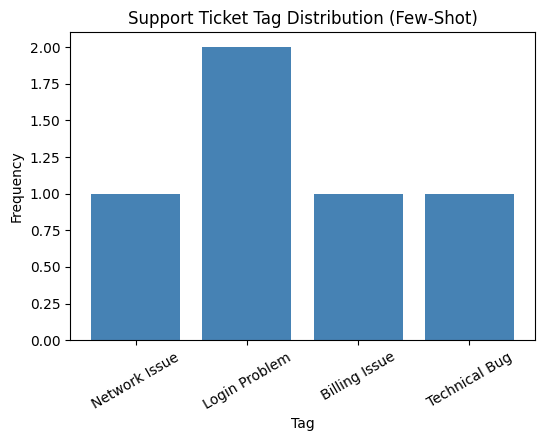

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(tag_counts.keys(), tag_counts.values(), color="steelblue")
plt.title("Support Ticket Tag Distribution (Few-Shot)")
plt.xlabel("Tag")
plt.ylabel("Frequency")
plt.xticks(rotation=30)
plt.show()

In [16]:
def count_valid_tags(output):
    return sum(tag in TAGS for tag in output.split(","))

df["zero_shot_valid"] = df["zero_shot_tags"].apply(count_valid_tags)
df["few_shot_valid"] = df["few_shot_tags_clean"].apply(len)

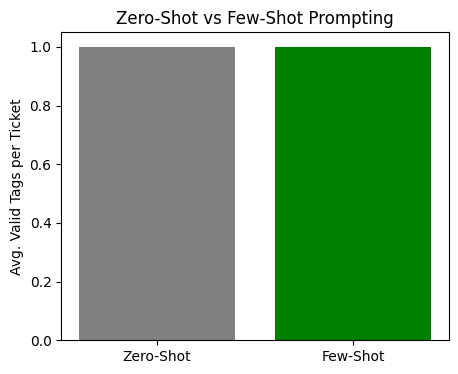

In [17]:
plt.figure(figsize=(5,4))
plt.bar(
    ["Zero-Shot", "Few-Shot"],
    [df["zero_shot_valid"].mean(), df["few_shot_valid"].mean()],
    color=["gray", "green"]
)
plt.ylabel("Avg. Valid Tags per Ticket")
plt.title("Zero-Shot vs Few-Shot Prompting")
plt.show()

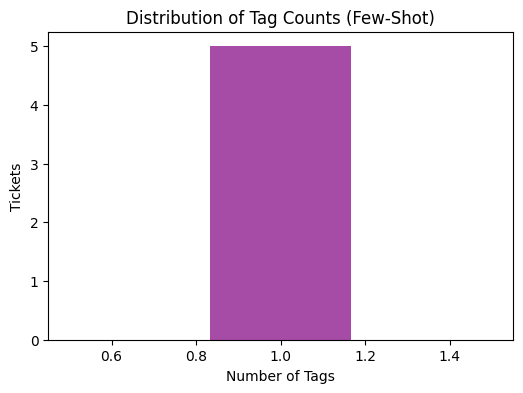

In [18]:
plt.figure(figsize=(6,4))
plt.hist(df["few_shot_valid"], bins=3, color="purple", alpha=0.7)
plt.title("Distribution of Tag Counts (Few-Shot)")
plt.xlabel("Number of Tags")
plt.ylabel("Tickets")
plt.show()

In [19]:
df[["ticket", "few_shot_tags_clean"]]

,ticket,few_shot_tags_clean
0,Internet connection drops frequently,[Network Issue]
1,Unable to reset my account password,[Login Problem]
2,Charged twice for my monthly subscription,[Billing Issue]
3,Application crashes when uploading files,[Technical Bug]
4,Need help changing my billing address,[Login Problem]
